# Simulation studies

(Move this notebook to the root directory to run it)

Note: For all these studies, the hyperparameter search has already been completed.

In [1]:
import sys
from pathlib import Path
import yaml
import pickle
import argparse
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter

from coxkan import CoxKAN
from coxkan.utils import bootstrap_metric, set_seed

SEED = set_seed(42)

In [2]:
### Reusable functions for the notebook

def true_cindex(df):
    global sim_config, duration_col, event_col, covariates
    lph = sim_config['log_partial_hazard'](**df[covariates])
    return concordance_index(df[duration_col], -lph, df[event_col])

def cph_cindex(df):
    global cph
    return cph.score(df, scoring_method='concordance_index')

def cph_formula(cph):
    coefficients = cph.params_
    terms = []
    for covariate, coefficient in coefficients.items():
        term = f"{coefficient:.4f} * {covariate}"
        terms.append(term)
    expression = " + ".join(terms)
    return expression

## Gaussian

For our first study, we set the log-partial hazard to be a Gaussian:

$$\theta(\mathbf{x}) = 5 \exp(-2 (x_1^2 + x_2^2))$$

In [3]:
exp_name = "sim_gaussian"
sim_name = "gaussian"

### load configs
with open(f'./configs/simulation/{sim_name}.yml', 'r') as file:
    sim_config = yaml.safe_load(file)
    sim_config['true_expr'] =  sim_config['log_partial_hazard'].split(': ')[-1] # log partial hazard expression
    sim_config['log_partial_hazard'] = eval(sim_config['log_partial_hazard']) # convert to function

# (config from hyperparameter search)
with open(f'configs/coxkan/{exp_name}.yml', 'r') as file:
    config = yaml.safe_load(file)

# data already generated (from sweep.py)
df_train = pd.read_csv(f'./data/{exp_name}_train.csv')
df_test = pd.read_csv(f'./data/{exp_name}_test.csv')
duration_col, event_col, covariates = 'duration', 'event', df_train.columns[:-2]

Evaluate performance of the 'true' expression. Clearly, the C-Index will not be perfect since survival time is randomly distributed.

In [4]:
# C-Index of true log partial hazard expression
cindex_true = bootstrap_metric(true_cindex, df_test, N=100)['formatted']

print(f"True log partial hazard: {sim_config['true_expr']}")
print(f"True C-Index: {cindex_true}")

True log partial hazard: 5*np.exp(-2*(x1**2 + x2**2))
True C-Index: 0.759744 (0.759, 0.760)


Evaluate Cox Proportional Hazards Model:

In [5]:
# CoxPH
cph = CoxPHFitter()
cph.fit(df_train, duration_col=duration_col, event_col=event_col)
cindex_cph = bootstrap_metric(cph_cindex, df_test, N=100)['formatted']
formula_cph = cph_formula(cph)
print(f"CoxPH Expression: {formula_cph}")
print(f"CoxPH C-Index: {cindex_cph}")

CoxPH Expression: -0.0009 * x1 + -0.0037 * x2 + 0.0159 * noise1 + -0.0134 * noise2
CoxPH C-Index: 0.499213 (0.497, 0.500)


Evaluate CoxKAN:

train loss: 2.76e+00 | val loss: 2.50e+00: 100%|██████████████████| 133/133 [00:18<00:00,  7.18it/s]


Pre-symbolic: 0.759630 (0.758, 0.761)
Saved model to checkpoints/sim_gaussian/model.pt


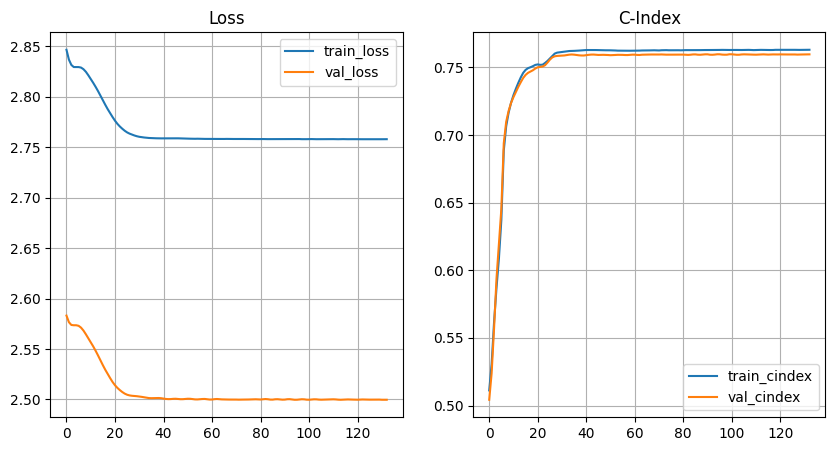

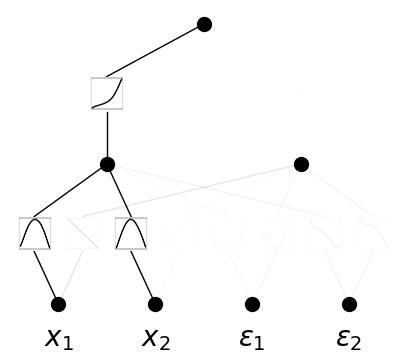

In [6]:
# CoxKAN
ckan = CoxKAN(seed=42, **config['init_params'])

log = ckan.train(df_train, df_test, duration_col, event_col, **config['train_params'])

cindex_pre = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(f"Pre-symbolic: {cindex_pre}")

# Save
ckan.save_ckpt(f'checkpoints/{exp_name}/model.pt')
fig = log.plot()
fig.savefig(f'checkpoints/{exp_name}/evolution.png')
fig = ckan.plot(beta=40, in_vars=[r'$x_1$', r'$x_2$', r'$\epsilon_1$', r'$\epsilon_2$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_pre.png', dpi=600)

Pruned activation (0,2,0)
Pruned activation (0,3,0)
Pruned: 0.759665 (0.758, 0.760)


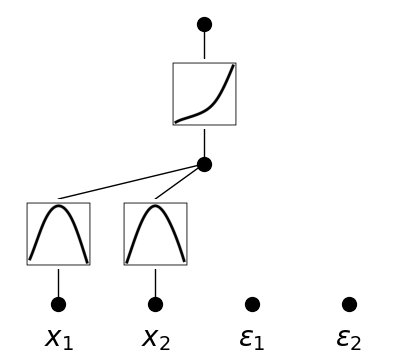

In [12]:
# Pruning
ckan = ckan.prune_nodes(config['prune_threshold'])
ckan.prune_edges(config['prune_threshold'], verbose=True)
fig = ckan.plot(beta=40, in_vars=[r'$x_1$', r'$x_2$', r'$\epsilon_1$', r'$\epsilon_2$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_pruned.png', dpi=600)
cindex_pruned = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(f"Pruned: {cindex_pruned}")

We can recognise these activation functions as `x^2, x^2, exp`. We try fitting these functions:

In [13]:
r2 = ckan.fix_symbolic(0, 0, 0, 'x^2', verbose=False)
print(f"Activation (0,0,0): x^2 fits with R^2: {r2}")
r2 = ckan.fix_symbolic(0, 1, 0, 'x^2', verbose=False)
print(f"Activation (0,1,0): x^2 fits with R^2: {r2}")
r2 = ckan.fix_symbolic(1, 0, 0, 'exp', verbose=False)
print(f"Activation (1,0,0): exp fits with R^2: {r2}")

formula = ckan.symbolic_formula()[0][0]
formula

Activation (0,0,0): x^2 fits with R^2: 0.9964995663082359
Activation (0,1,0): x^2 fits with R^2: 0.994506978921789
Activation (1,0,0): exp fits with R^2: 0.9986235209116605


4.85*exp(-1.7*x1**2 - 1.67*x2**2)

The high $R^2$ values (coefficient of determination) verify that the true expression was learnt. However, the affine parameters are not quite correct (although a close approximation). We finish by training the affine params:

In [14]:
ckan.train(df_train, df_test, duration_col, event_col, opt="LBFGS", steps=50)
formula = ckan.symbolic_formula()[0][0]
formula

train loss: 2.76e+00 | val loss: 2.50e+00: 100%|████████████████████| 50/50 [00:11<00:00,  4.50it/s]


4.98*exp(-1.99*x1**2 - 1.99*x2**2)

We see that the result is near-perfect. Now we just save the results/visualisations:

Symbolic: 0.759739 (0.760, 0.762)


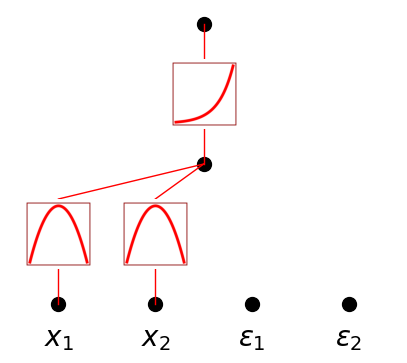

In [15]:
fig = ckan.plot(beta=40, in_vars=[r'$x_1$', r'$x_2$', r'$\epsilon_1$', r'$\epsilon_2$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_symbolic.png', dpi=600)
cindex_symbolic = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(f"Symbolic: {cindex_symbolic}")

results = {
    'cindex_true': cindex_true,
    'cindex_cph': cindex_cph,
    'cindex_pre': cindex_pre,
    'cindex_pruned': cindex_pruned,
    'cindex_symbolic': cindex_symbolic,
    'coxkan_formula': formula,
    'coxph_formula': formula_cph,
}

with open(f'checkpoints/{exp_name}/results.pkl', 'wb') as f:
    pickle.dump(results, f)

## Shallow

In survival analysis, it is common that we encounter covariates that satisfy the linear Cox Proportional Hazards model after some non-linear transformation. In other words, they have non-linear relationships to the patient's risk but they do not interact. To simulate this situation we use the following expression for the log-partial hazard:

$$\theta(\mathbf{x}) = \tanh(5x_1) + \sin(2\pi x_2) + x_3^2$$

This can be captured by a shallow KAN (no hidden layers).

In [302]:
exp_name = "sim_depth_1"
sim_name = "depth_1"

### load configs
with open(f'./configs/simulation/{sim_name}.yml', 'r') as file:
    sim_config = yaml.safe_load(file)
    sim_config['true_expr'] =  sim_config['log_partial_hazard'].split(': ')[-1] # log partial hazard expression
    sim_config['log_partial_hazard'] = eval(sim_config['log_partial_hazard']) # convert to function

# (config from hyperparameter search)
with open(f'configs/coxkan/{exp_name}.yml', 'r') as file:
    config = yaml.safe_load(file)

# data already generated (from sweep.py)
df_train = pd.read_csv(f'./data/{exp_name}_train.csv')
df_test = pd.read_csv(f'./data/{exp_name}_test.csv')
duration_col, event_col, covariates = 'duration', 'event', df_train.columns[:-2]

Evaluate true expression:

In [303]:
# C-Index of true log partial hazard expression
cindex_true = bootstrap_metric(true_cindex, df_test, N=100)['formatted']

print(f"True log partial hazard: {sim_config['true_expr']}")
print(f"True C-Index: {cindex_true}")

True log partial hazard: np.tanh(5*x1) + np.sin(2*np.pi*x2) + x3**2
True C-Index: 0.759795 (0.759, 0.761)


Evaluate Cox proportional hazards model:

In [304]:
# CoxPH
cph = CoxPHFitter()
cph.fit(df_train, duration_col=duration_col, event_col=event_col)
cindex_cph = bootstrap_metric(cph_cindex, df_test, N=100)['formatted']
formula_cph = cph_formula(cph)
print(f"CoxPH Expression: {formula_cph}")
print(f"CoxPH C-Index: {cindex_cph}")

CoxPH Expression: 1.1208 * x1 + -0.3440 * x2 + 0.0096 * x3 + -0.0136 * noise1 + 0.0324 * noise2
CoxPH C-Index: 0.688116 (0.688, 0.690)


CoxKAN:

train loss: 2.76e+00 | val loss: 2.50e+00: 100%|██████████████████| 107/107 [00:11<00:00,  8.99it/s]


Pre-symbolic: 0.759048 (0.759, 0.760)
Saved model to checkpoints/sim_depth_1/model.pt


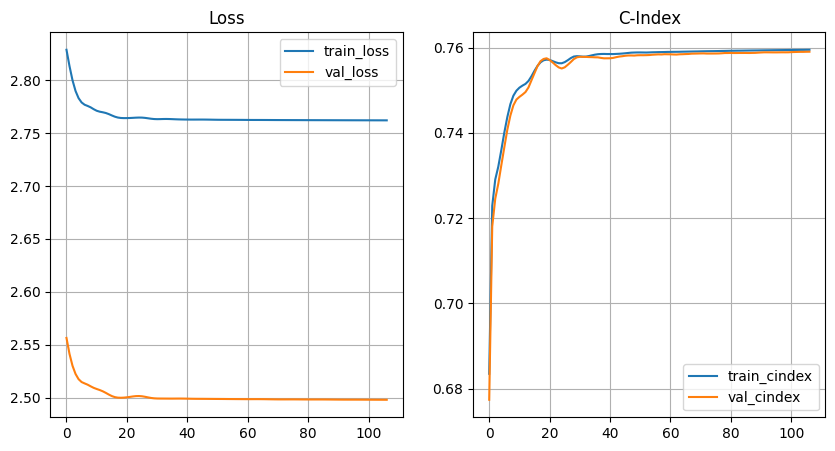

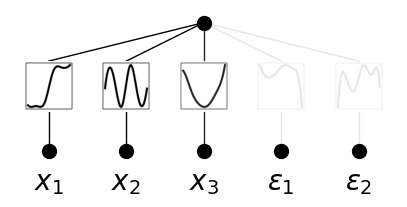

In [310]:
# CoxKAN
ckan = CoxKAN(seed=42, **config['init_params'])

log = ckan.train(df_train, df_test, duration_col, event_col, **config['train_params'])

cindex_pre = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(f"Pre-symbolic: {cindex_pre}")

# Save
ckan.save_ckpt(f'checkpoints/{exp_name}/model.pt')
fig = log.plot()
fig.savefig(f'checkpoints/{exp_name}/evolution.png', bbox_inches='tight')
fig = ckan.plot(beta=10, in_vars=[r'$x_1$', r'$x_2$', r'$x_3$',r'$\epsilon_1$', r'$\epsilon_2$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_pre.png', bbox_inches='tight')

Pruned activation (0,3,0)
Pruned activation (0,4,0)
Pruned: 0.759613 (0.759, 0.761)


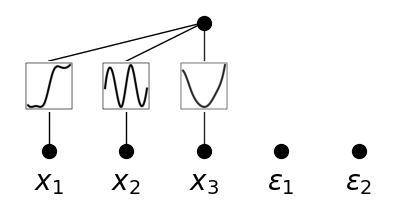

In [311]:
# Pruning
ckan = ckan.prune_nodes(config['prune_threshold'])
ckan.prune_edges(config['prune_threshold'], verbose=True)
fig = ckan.plot(beta=10, in_vars=[r'$x_1$', r'$x_2$', r'$x_3$',r'$\epsilon_1$', r'$\epsilon_2$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_pruned.png', bbox_inches='tight')
cindex_pruned = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(f"Pruned: {cindex_pruned}")

We can again recognise these activations: 
- some s-shaped function like `tanh` or `sigmoid`
- some oscillating function like `sin` (or `cos` but this is just a matter of affine parameters)
- a quadratic `x^2`

In the case of the s-shaped function we try out both options and see which is better:

In [312]:
_ = ckan.predict(df_test)
fn, _, r2 = ckan.suggest_symbolic(0, 0, 0, lib=['tanh', 'sigmoid'], verbose=False)
print(f"Best: {fn} fits with R^2: {r2}")

Best: tanh fits with R^2: 0.998593616057503


In [313]:
r2 = ckan.fix_symbolic(0, 0, 0, 'tanh', verbose=False)
print(f"Activation (0,0,0): tanh fits with R^2: {r2}")
r2 = ckan.fix_symbolic(0, 1, 0, 'sin', verbose=False)
print(f"Activation (0,1,0): sin fits with R^2: {r2}")
r2 = ckan.fix_symbolic(0, 2, 0, 'x^2', verbose=False)
print(f"Activation (0,2,0): x^2 fits with R^2: {r2}")

formula = ckan.symbolic_formula()[0][0]
formula

Activation (0,0,0): tanh fits with R^2: 0.998593616057503
Activation (0,1,0): sin fits with R^2: 0.9936378892045175
Activation (0,2,0): x^2 fits with R^2: 0.9947961785410196


0.99*x3**2 - 0.96*sin(6.27*x2 - 9.4) + 1.03*tanh(5.13*x1 - 0.e-2)

The high $R^2$ values (coefficient of determination) verify that the true expression was learnt. On first glance, the `sin` term appears incorrect, but note that: $ - 0.96 \sin(6.27x + 12.58) \approx -\sin(2\pi x - 3\pi) = \sin(2\pi x)$

Symbolic: 0.759562 (0.759, 0.761)


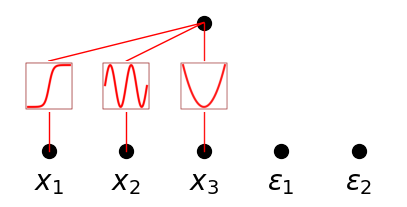

In [315]:
_ = ckan.predict(df_test)
fig = ckan.plot(beta=10, in_vars=[r'$x_1$', r'$x_2$', r'$x_3$',r'$\epsilon_1$', r'$\epsilon_2$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_symbolic.png', bbox_inches='tight')
cindex_symbolic = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(f"Symbolic: {cindex_symbolic}")

results = {
    'cindex_true': cindex_true,
    'cindex_cph': cindex_cph,
    'cindex_pre': cindex_pre,
    'cindex_pruned': cindex_pruned,
    'cindex_symbolic': cindex_symbolic,
    'coxkan_formula': formula,
    'coxph_formula': formula_cph,
}

with open(f'checkpoints/{exp_name}/results.pkl', 'wb') as f:
    pickle.dump(results, f)

Note that in this case, training the affine parameters doesnt yield a better expression:

In [265]:
ckan.train(df_train, df_test, duration_col, event_col, opt="LBFGS", steps=50)
formula = ckan.symbolic_formula()[0][0]
formula

train loss: 2.76e+00 | val loss: 2.50e+00: 100%|████████████████████| 50/50 [00:07<00:00,  6.76it/s]


0.99*(0.01 - x3)**2 - 0.97*sin(6.26*x2 - 9.4) + 1.03*tanh(5.19*x1 - 0.e-2)

This is likely due to the noise in the dataset - we can only get an approximation.

## Deep

To contrast with the previous example, we now try an expression for the log-partial hazard that requires a deep KAN (2 hidden layers) to capture:

$$\theta(\mathbf{x}) = 2\sqrt{(x_1-x_2)^2 + (x_3-x_4)^2}$$

In [3]:
exp_name = "sim_deep"
sim_name = "deep"

# load configs
with open(f'./configs/simulation/{sim_name}.yml', 'r') as file:
    sim_config = yaml.safe_load(file)
    sim_config['true_expr'] =  sim_config['log_partial_hazard'].split(': ')[-1] # log partial hazard expression
    sim_config['log_partial_hazard'] = eval(sim_config['log_partial_hazard']) # convert to function

with open(f'configs/coxkan/{exp_name}.yml', 'r') as file:
    config = yaml.safe_load(file)

# data already generated (from sweep.py)
df_train = pd.read_csv(f'./data/{exp_name}_train.csv')
df_test = pd.read_csv(f'./data/{exp_name}_test.csv')
duration_col, event_col, covariates = 'duration', 'event', df_train.columns[:-2]

In [4]:
# C-Index of true log partial hazard expression
cindex_true = bootstrap_metric(true_cindex, df_test, N=100)['formatted']

print(f"True log partial hazard: {sim_config['true_expr']}")
print(f"True C-Index: {cindex_true}")

True log partial hazard: 2*np.sqrt((x1-x2)**2 + (x3-x4)**2)
True C-Index: 0.725470 (0.725, 0.727)


In [5]:
# CoxPH
cph = CoxPHFitter()
cph.fit(df_train, duration_col=duration_col, event_col=event_col)
cindex_cph = bootstrap_metric(cph_cindex, df_test, N=100)['formatted']
formula_cph = cph_formula(cph)
print(f"CoxPH Expression: {formula_cph}")
print(f"CoxPH C-Index: {cindex_cph}")

CoxPH Expression: -0.0275 * x1 + 0.0507 * x2 + 0.0266 * x3 + 0.0120 * x4 + -0.0303 * noise1 + 0.0274 * noise2
CoxPH C-Index: 0.511198 (0.508, 0.511)


For this study (perhaps due to its difficulty), the hyperparameter search yielded early_stopping=True - hence we need to split the training set into a train and a validation set.

train loss: 2.74e+00 | val loss: 2.47e+00: 100%|██████████████████| 300/300 [01:48<00:00,  2.76it/s]


Best model loaded (early stopping).
Pre-symbolic: 0.721932 (0.721, 0.723)
Saved model to checkpoints/sim_deep/model.pt


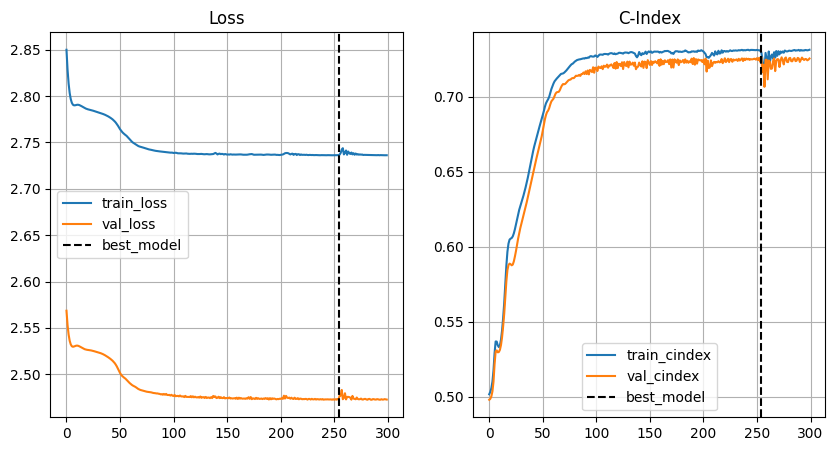

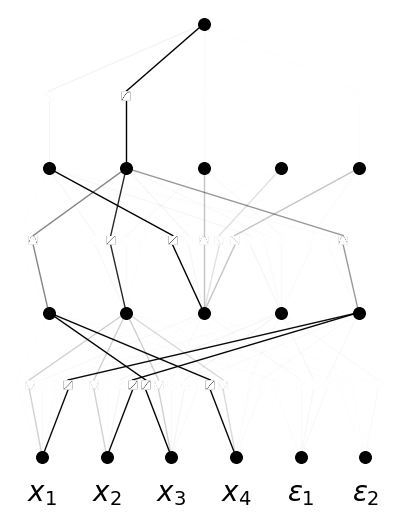

In [6]:
from sklearn.model_selection import train_test_split

# CoxKAN
ckan = CoxKAN(seed=42, **config['init_params'])

# Train/Val split for early stopping
train, val = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train['event'])

log = ckan.train(train, val, duration_col, event_col, **config['train_params'])

cindex_pre = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(f"Pre-symbolic: {cindex_pre}")

# Save
ckan.save_ckpt(f'checkpoints/{exp_name}/model.pt')
fig = log.plot()
fig.savefig(f'checkpoints/{exp_name}/evolution.png')
fig = ckan.plot(beta=20, in_vars=[r'$x_1$', r'$x_2$', r'$x_3$', r'$x_4$', r'$\epsilon_1$', r'$\epsilon_2$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_pre.png')

Another benefit of using a validation set, is that we can use it to select a more optimal pruning threshold:

In [7]:
# search for pruning thresholds
pruning_thresholds = np.linspace(0, 0.05, 20)
pruning_thresholds[0] = config['prune_threshold']
cindices = []
for threshold in pruning_thresholds:
    ckan_ = CoxKAN(seed=42, **config['init_params'])
    ckan_.load_ckpt(f'checkpoints/{exp_name}/model.pt', verbose=False)
    _ = ckan_.predict(df_test) # important forward pass after loading a model
    
    prunable = True
    for l in range(ckan_.depth):
        if not (ckan_.acts_scale[l] > threshold).any():
            prunable = False
            break
        
    ckan_ = ckan_.prune_nodes(threshold)
    if 0 in ckan_.width: prunable = False
    if not prunable:
        if threshold == config['prune_threshold']: 
            cindices.append(0)
            continue
        else: break

    _ = ckan_.predict(df_test) # important forward pass
    ckan_.prune_edges(threshold, verbose=False)
    cindices.append(ckan_.cindex(val))
    print(f'Pruning threshold: {threshold:.2f}, C-Index (Val): {cindices[-1]:.6f}')
best_threshold = pruning_thresholds[np.argmax(cindices)]
if np.max(cindices) < 0.51: best_threshold = 0

Pruning threshold: 0.00, C-Index (Val): 0.726730
Pruning threshold: 0.01, C-Index (Val): 0.726730
Pruning threshold: 0.01, C-Index (Val): 0.697206
Pruning threshold: 0.01, C-Index (Val): 0.603269
Pruning threshold: 0.01, C-Index (Val): 0.603269
Pruning threshold: 0.02, C-Index (Val): 0.603269
Pruning threshold: 0.02, C-Index (Val): 0.603269
Pruning threshold: 0.02, C-Index (Val): 0.603269
Pruning threshold: 0.02, C-Index (Val): 0.568391


Pruned activation (0,0,0)
Pruned activation (0,1,0)
Pruned activation (0,2,2)
Pruned activation (0,3,2)
Pruned activation (0,4,0)
Pruned activation (0,4,1)
Pruned activation (0,4,2)
Pruned activation (0,5,0)
Pruned activation (0,5,1)
Pruned activation (0,5,2)
Pruned: 0.721721 (0.720, 0.723)


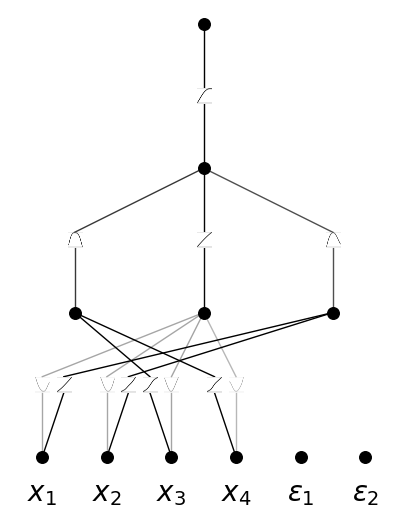

In [8]:
# Pruning
_ = ckan.predict(df_test)
ckan = ckan.prune_nodes(best_threshold)
_ = ckan.predict(df_test)
ckan.prune_edges(best_threshold, verbose=True)
fig = ckan.plot(beta=40, in_vars=[r'$x_1$', r'$x_2$', r'$x_3$', r'$x_4$', r'$\epsilon_1$', r'$\epsilon_2$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_pruned.png')
cindex_pruned = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(f"Pruned: {cindex_pruned}")

We examine these activations and fix them accordingly:

In [9]:
r2 = ckan.fix_symbolic(0, 0, 1, 'x^2', verbose=False)
print(f"Activation (0,0,1): x^2 fits with R^2: {r2.item()}")

r2 = ckan.fix_symbolic(0, 1, 1, 'x^2', verbose=False)
print(f"Activation (0,1,1): x^2 fits with R^2: {r2.item()}")

r2 = ckan.fix_symbolic(0, 2, 1, 'x^2', verbose=False)
print(f"Activation (0,2,1): x^2 fits with R^2: {r2.item()}")

r2 = ckan.fix_symbolic(0, 3, 1, 'x^2', verbose=False)
print(f"Activation (0,3,1): x^2 fits with R^2: {r2.item()}")

r2 = ckan.fix_symbolic(0, 0, 2, 'x', verbose=False)
print(f"Activation (0,0,2): x fits with R^2: {r2.item()}")
                       
r2 = ckan.fix_symbolic(0, 1, 2, 'x', verbose=False)
print(f"Activation (0,1,2): x fits with R^2: {r2.item()}")

r2 = ckan.fix_symbolic(0, 2, 0, 'x', verbose=False)
print(f"Activation (0,2,0): x fits with R^2: {r2.item()}")
                       
r2 = ckan.fix_symbolic(0, 3, 0, 'x', verbose=False)
print(f"Activation (0,3,0): x fits with R^2: {r2.item()}")

r2 = ckan.fix_symbolic(1, 0, 0, 'x^2', verbose=False)
print(f"Activation (1,0,0): x^2 fits with R^2: {r2.item()}")

r2 = ckan.fix_symbolic(1, 1, 0, 'x', verbose=False)
print(f"Activation (1,1,0): x^2 fits with R^2: {r2.item()}")

r2 = ckan.fix_symbolic(1, 2, 0, 'x^2', verbose=False)
print(f"Activation (1,2,0): x^2 fits with R^2: {r2.item()}")

r2 = ckan.fix_symbolic(2, 0, 0, 'sqrt', verbose=False)
print(f"Activation (2,0,0): sqrt fits with R^2: {r2.item()}")

Activation (0,0,1): x^2 fits with R^2: 0.9980210334762838
Activation (0,1,1): x^2 fits with R^2: 0.9928818180001265
Activation (0,2,1): x^2 fits with R^2: 0.9806605016648312
Activation (0,3,1): x^2 fits with R^2: 0.9900266461006783
Activation (0,0,2): x fits with R^2: 0.996598658923094
Activation (0,1,2): x fits with R^2: 0.9885720893395259
Activation (0,2,0): x fits with R^2: 0.9875133641888981
Activation (0,3,0): x fits with R^2: 0.9923045132028118
Activation (1,0,0): x^2 fits with R^2: 0.983644133833923
Activation (1,1,0): x^2 fits with R^2: 0.9988926337553825
Activation (1,2,0): x^2 fits with R^2: 0.988922510591304
Activation (2,0,0): sqrt fits with R^2: 0.9930669177521573


The high $R^2$ in each case verifies that these functions have been learned.

Symbolic: 0.722706 (0.721, 0.723)


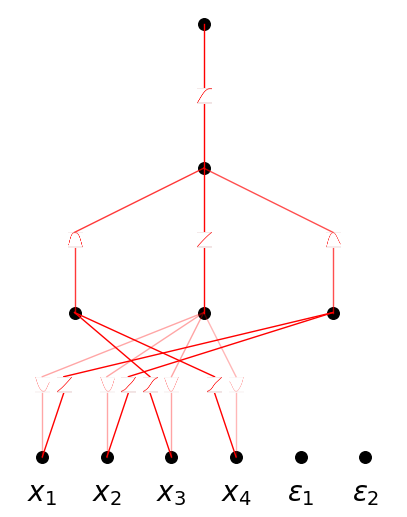

In [10]:
formula = ckan.symbolic_formula()[0][0]

fig = ckan.plot(beta=40, in_vars=[r'$x_1$', r'$x_2$', r'$x_3$', r'$x_4$', r'$\epsilon_1$', r'$\epsilon_2$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_symbolic.png')
cindex_symbolic = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(f"Symbolic: {cindex_symbolic}")

results = {
    'cindex_true': cindex_true,
    'cindex_cph': cindex_cph,
    'cindex_pre': cindex_pre,
    'cindex_pruned': cindex_pruned,
    'cindex_symbolic': cindex_symbolic,
    'coxkan_formula': formula,
    'coxph_formula': formula_cph,
}

with open(f'checkpoints/{exp_name}/results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [285]:
formula

3.97*sqrt(0.96*(0.06 - x2)**2 + 0.94*(0.09 - x1)**2 + (-x3 - 0.04)**2 + 0.79*(-x4 - 0.04)**2 - 0.5*(-0.97*x1 - x2 + 0.14)**2 - 0.67*(-x3 - 0.71*x4 - 0.06)**2 + 0.56)

The affine parameters are not quite right. However, if we take some liberal approximations, we see that it has captured the true expression:

$ 3.97 \sqrt{0.96*(0.06 - x_2)^2 + 0.94*(0.09 - x_1)^2 + (-x_3 - 0.04)^2 + 0.79*(-x_4 - 0.04)^2 - 0.5*(-0.97*x_1 - x_2 + 0.14)^2 - 0.67*(-x_3 - 0.71*x_4 - 0.06)^2 + 0.56} $

$ \approx 4 \sqrt{x_2^2 + x_1^2 + x_3^2 + x_4^2 - \frac{1}{2}(x_1 + x_2)^2 - \frac{1}{2}(x_3 + x_4)^2} $

$ = 2 \sqrt{2x_1^2 + 2x_2^2 + 2x_3^2 + 2x_4^2 - (x_1 + x_2)^2 - (x_3 + x_4)^2} $

$ = 2 \sqrt{x_1^2 + x_2^2 - 2x_1x_2 + x_3^2 + x_4^2 - 2x_3x_4}$

$ = 2 \sqrt{(x_1 - x_2)^2 + (x_3 - x_4)^2}$

Obviously, in the case of a real dataset, we would not be able to make these reckless approximations, nor would we necessarily go through spotting all these activations as their 'true' symbolic counterparts. In the next example, we will see an example where we instead just call `auto_symbolic` rather than recognising activations by eye. 

## Intentionally difficult dataset

Next we use an expression for the log-partial hazard which is intentionally difficult to capture.

$$\theta(\mathbf{x}) = \tanh(5(\log(x_1) + |x_2|))$$

The intuitition behind this choice is that
- $\tanh(5z)$ has a very shallow gradient in much of its domain, hence there will not be much of a training signal when comparing subjects in these regions.
- $|x_2|$ is non-smooth. KAN activations use B-Splines which are necessarily smooth - thus this activation is likely to be difficult to learn. 

In [296]:
exp_name = "sim_difficult"
sim_name = "difficult"

# load configs
with open(f'./configs/simulation/{sim_name}.yml', 'r') as file:
    sim_config = yaml.safe_load(file)
    sim_config['true_expr'] =  sim_config['log_partial_hazard'].split(': ')[-1] # log partial hazard expression
    sim_config['log_partial_hazard'] = eval(sim_config['log_partial_hazard']) # convert to function

with open(f'configs/coxkan/{exp_name}.yml', 'r') as file:
    config = yaml.safe_load(file)

# data already generated (from sweep.py)
df_train = pd.read_csv(f'./data/{exp_name}_train.csv')
df_test = pd.read_csv(f'./data/{exp_name}_test.csv')
duration_col, event_col, covariates = 'duration', 'event', df_train.columns[:-2]

In [297]:
# C-Index of true log partial hazard expression
cindex_true = bootstrap_metric(true_cindex, df_test, N=100)['formatted']

print(f"True log partial hazard: {sim_config['true_expr']}")
print(f"True C-Index: {cindex_true}")

True log partial hazard: np.tanh(5*(np.log(x1) + np.abs(x2)))
True C-Index: 0.690174 (0.689, 0.692)


In [298]:
# CoxPH
cph = CoxPHFitter()
cph.fit(df_train, duration_col=duration_col, event_col=event_col)
cindex_cph = bootstrap_metric(cph_cindex, df_test, N=100)['formatted']
formula_cph = cph_formula(cph)
print(f"CoxPH Expression: {formula_cph}")
print(f"CoxPH C-Index: {cindex_cph}")

CoxPH Expression: 2.0720 * x1 + 0.0511 * x2 + 0.0289 * noise1 + -0.0110 * noise2
CoxPH C-Index: 0.663698 (0.663, 0.666)


train loss: 2.79e+00 | val loss: 2.53e+00: 100%|██████████████████| 125/125 [00:16<00:00,  7.47it/s]


Pre-symbolic: 0.691461 (0.691, 0.693)
Saved model to checkpoints/sim_difficult/model.pt


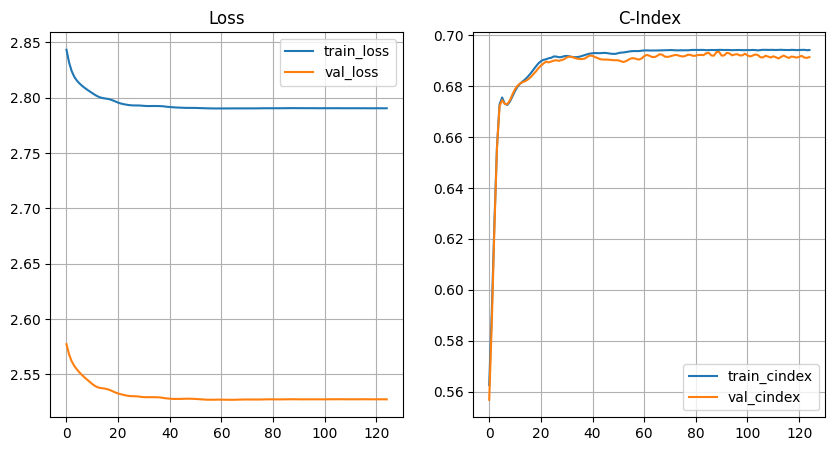

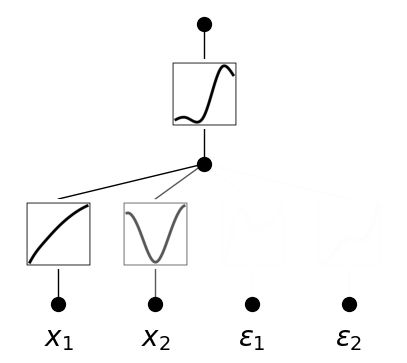

In [299]:
# CoxKAN
ckan = CoxKAN(seed=42, **config['init_params'])

log = ckan.train(df_train, df_test, duration_col, event_col, **config['train_params'])

cindex_pre = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(f"Pre-symbolic: {cindex_pre}")

# Save
ckan.save_ckpt(f'checkpoints/{exp_name}/model.pt')
fig = log.plot()
fig.savefig(f'checkpoints/{exp_name}/evolution.png')
fig = ckan.plot(beta=10, in_vars=[r'$x_1$', r'$x_2$', r'$\epsilon_1$', r'$\epsilon_2$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_pre.png')

Pruned activation (0,2,0)
Pruned activation (0,3,0)
Pruned: 0.691510 (0.691, 0.693)


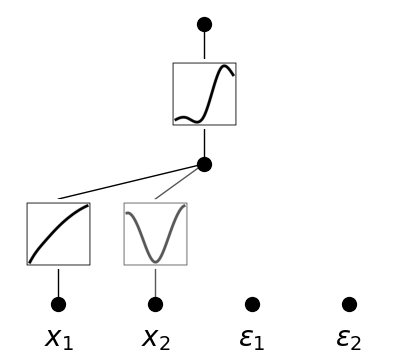

In [300]:
# Pruning
ckan = ckan.prune_nodes(config['prune_threshold'])
ckan.prune_edges(config['prune_threshold'], verbose=True)
fig = ckan.plot(beta=10, in_vars=[r'$x_1$', r'$x_2$', r'$\epsilon_1$', r'$\epsilon_2$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_pruned.png')
cindex_pruned = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(f"Pruned: {cindex_pruned}")

Although the activations do seem to be close to their 'true' counterparts, we would not naturally recognise them by eye. As we expected, the model appears to have had issues with the `tanh` (parts of the domain that should be flat are not bumpy) and `abs` (too smooth at the bottom). 

Hence, instead of recognising activations by eye, we simply call `auto_symbolic`. 

fixing (0,0,0) with cosh, r2=0.9998434663834311
fixing (0,1,0) with gaussian, r2=0.9959983831663001
skipping (0,2,0) since already symbolic
skipping (0,3,0) since already symbolic
fixing (1,0,0) with tanh, r2=0.9936672560186781
Symbolic: 0.690194 (0.689, 0.692)


-1.04*tanh(31.43*cosh(0.45*x1 - 0.68) - 35.57 + 2.95*exp(-2.64*(x2 + 0.01)**2))

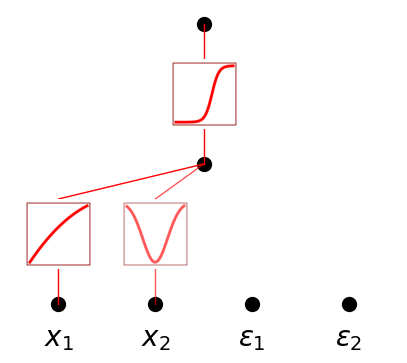

In [301]:
_ = ckan.auto_symbolic()

_ = ckan.predict(df_test)
fig = ckan.plot(beta=10, in_vars=[r'$x_1$', r'$x_2$', r'$\epsilon_1$', r'$\epsilon_2$'])
fig.savefig(f'checkpoints/{exp_name}/coxkan_symbolic.png')
cindex_symbolic = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(f"Symbolic: {cindex_symbolic}")
formula = ckan.symbolic_formula()[0][0]
formula

Surprisingly, the `tanh` activation was recovered, and the symbolic fitting actually smoothed out some of the noisy bumps, yielding a better result. Unforunately, the other activations were not recovered. 

However, the C-Index is very close to that of the true expression, suggesting that our expression is a close approximation in the relevant domain. We now plot the true and predicted expressions:

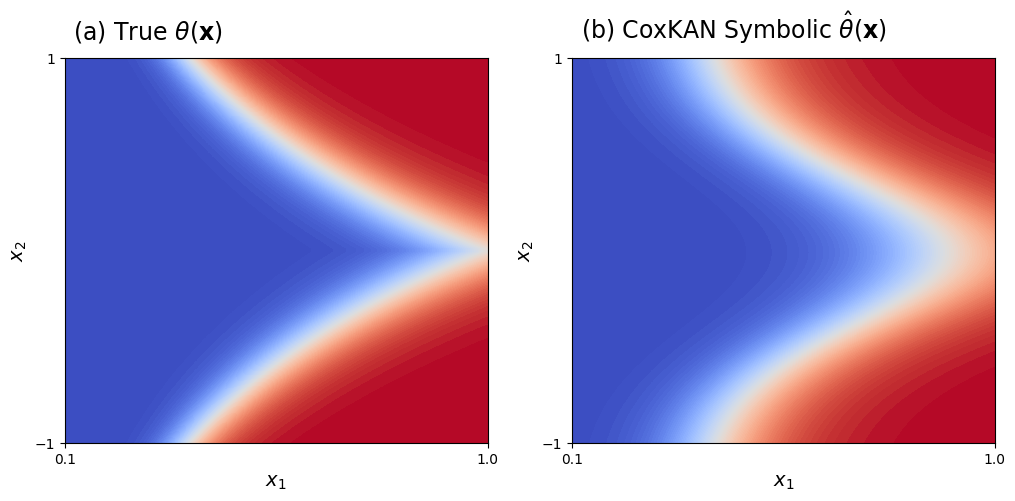

In [293]:
import torch 
import numpy as np

x1_range=(0.1, 1)
x2_range=(-1, 1)

# create grid of x1 and x2 values
x1 = np.linspace(*x1_range, 100)
x2 = np.linspace(*x2_range, 100)
X = np.meshgrid(x1, x2)
X = np.array(X).reshape(2, -1).T
X = torch.tensor(X, dtype=torch.float64)

# add noise
X = torch.cat([X, torch.zeros_like(X)[:, :2]], dim=1)

# get the predicted log partial hazard
lph_true = sim_config['log_partial_hazard'](X[:,0], X[:,1], *X[:,2:].T)

with torch.no_grad():
    lph_pred = ckan(X)
lph_pred = lph_pred.detach().numpy().flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# plot the true log partial hazard
levels = np.linspace(lph_true.min(), lph_true.max(), 100)
contour = axes[0].tricontourf(X[:,0], X[:,1], lph_true, levels=levels, cmap='coolwarm')
axes[0].set_xlabel(r'$x_1$', fontsize=14)
axes[0].set_ylabel(r'$x_2$', fontsize=14)
axes[0].set_xticks(x1_range)
axes[0].set_yticks(x2_range)

# plot the predicted log partial hazard
levels = np.linspace(lph_pred.min(), lph_pred.max(), 100)
contour = axes[1].tricontourf(X[:,0], X[:,1], lph_pred, levels=levels, cmap='coolwarm')
axes[1].set_xlabel(r'$x_1$', fontsize=14)
axes[1].set_ylabel(r'$x_2$', fontsize=14)
axes[1].set_xticks(x1_range)
axes[1].set_yticks(x2_range)

axes[0].text(0.02, 1.05, r'(a) True $\theta(\mathbf{x})$', fontsize=17, transform=axes[0].transAxes)
axes[1].text(0.02, 1.05, r'(b) CoxKAN Symbolic $\hat{\theta}(\mathbf{x})$', fontsize=17, transform=axes[1].transAxes)

fig.savefig(f'checkpoints/{exp_name}/lph_surfaces.png')

We see that indeed, the predicted expression is a very close approximation to the truth. 

I argue that CoxKAN still has the properties of high performance and interpretability in this case.

In [294]:
results = {
    'cindex_true': cindex_true,
    'cindex_cph': cindex_cph,
    'cindex_pre': cindex_pre,
    'cindex_pruned': cindex_pruned,
    'cindex_symbolic': cindex_symbolic,
    'coxkan_formula': formula,
    'coxph_formula': formula_cph,
}

with open(f'checkpoints/{exp_name}/results.pkl', 'wb') as f:
    pickle.dump(results, f)